<a href="https://colab.research.google.com/github/VyHoa1613/Demo_VGG19/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/VGG19"
!unzip -u "archive" -d "dataset"

In [ ]:
pip install tensorflow

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
# from tensorflow.python.keras.applications.resnet50 import ResNet50
from keras.applications import VGG19
import cv2
import os
import random
import tensorflow as tf
import numpy as np

In [ ]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
data = get_data("/content/drive/MyDrive/VGG19/dataset/flowers")

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


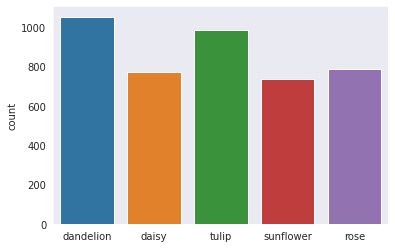

In [ ]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(l)

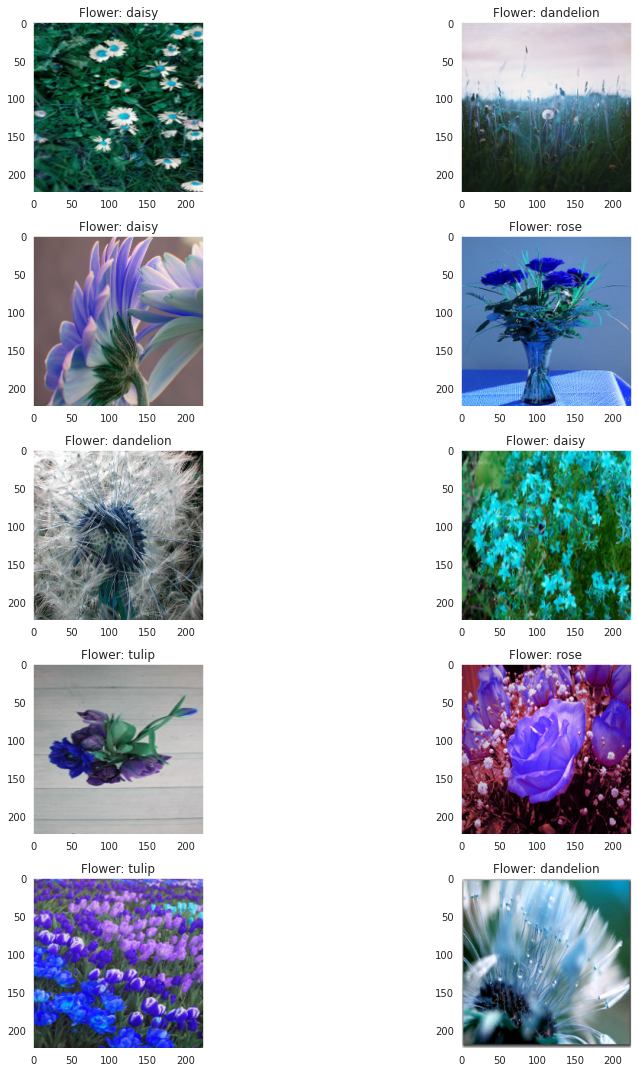

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

In [ ]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

In [ ]:
# Normalize the data
x = np.array(x) / 255

In [ ]:

x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 0)

In [ ]:
del x,y,data

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

    model = Sequential([
        pre_trained_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(5 , activation='softmax')])
    model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 23045     
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(x_train,y_train, batch_size = 64 , epochs = 4 , validation_data = (x_test, y_test),callbacks = [learning_rate_reduction])

Epoch 1/4
55/55 [==============================] - 2920s 53s/step - loss: 1.4431 - accuracy: 0.4969 - val_loss: 0.5860 - val_accuracy: 0.7827
Epoch 2/4
55/55 [==============================] - 2924s 53s/step - loss: 0.4489 - accuracy: 0.8365 - val_loss: 0.4752 - val_accuracy: 0.8347
Epoch 3/4
55/55 [==============================] - 2913s 53s/step - loss: 0.2530 - accuracy: 0.9142 - val_loss: 0.5017 - val_accuracy: 0.8405
Epoch 4/4
55/55 [==============================] - 2877s 52s/step - loss: 0.2270 - accuracy: 0.9186 - val_loss: 0.5553 - val_accuracy: 0.8324


In [ ]:
model.save("vgg19_demo_h2")

INFO:tensorflow:Assets written to: vgg19_demo_h2/assets


In [ ]:
saved_model = tf.keras.models.load_model("vgg19_demo_h2")

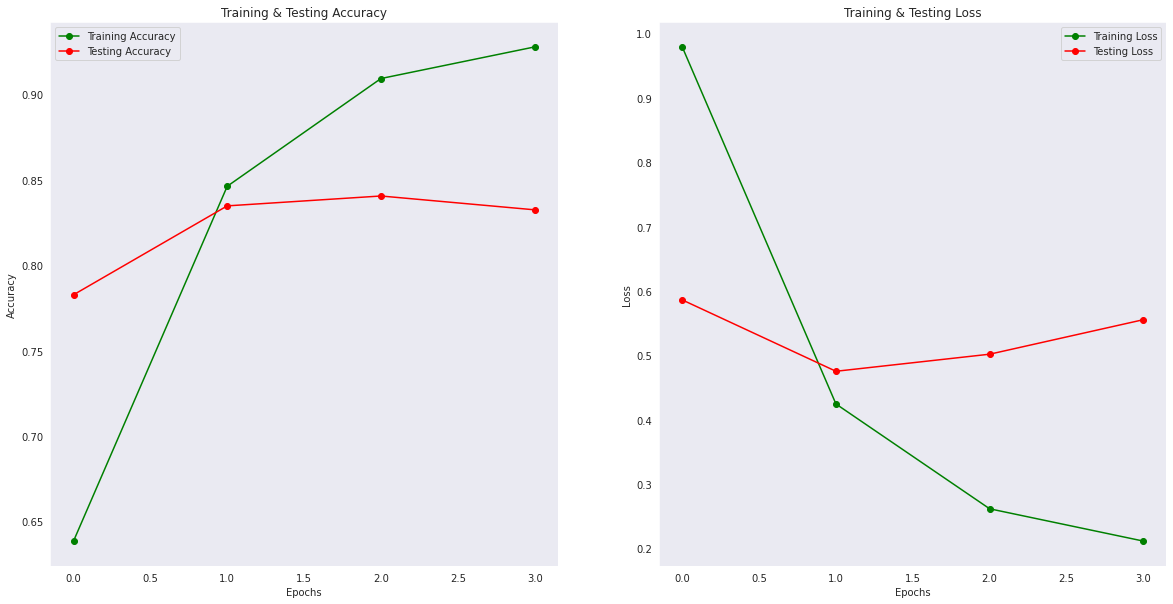

In [ ]:
epochs = [i for i in range(4)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
predictions[0:5]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 2, 4, 4, 3])

In [ ]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [ ]:
print(classification_report(y_test_inv, predictions, target_names = labels))


              precision    recall  f1-score   support

   dandelion       0.83      0.92      0.87       210
       daisy       0.96      0.62      0.75       154
       tulip       0.75      0.88      0.81       197
   sunflower       0.90      0.87      0.88       147
        rose       0.82      0.83      0.82       157

    accuracy                           0.83       865
   macro avg       0.85      0.82      0.83       865
weighted avg       0.84      0.83      0.83       865



In [ ]:
cm = confusion_matrix(y_test_inv,predictions)
cm

array([[194,   1,   6,   4,   5],
       [ 29,  95,  16,   9,   5],
       [  4,   0, 173,   2,  18],
       [  3,   1,  14, 128,   1],
       [  4,   2,  21,   0, 130]])

In [ ]:
import pandas as pd

In [ ]:
cm = pd.DataFrame(cm , index = labels , columns = labels)

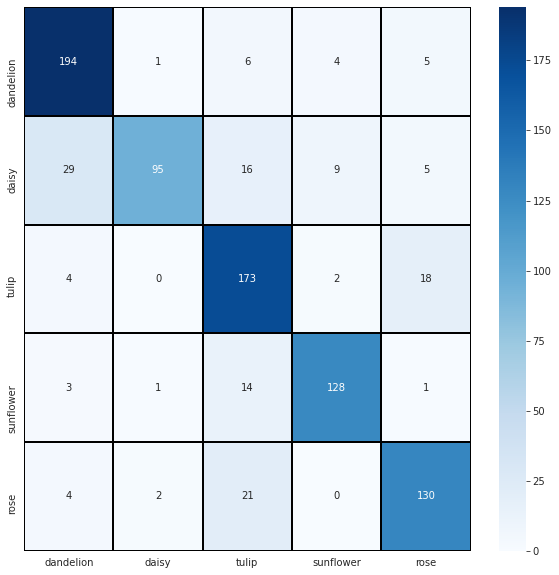

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = labels , yticklabels = labels)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

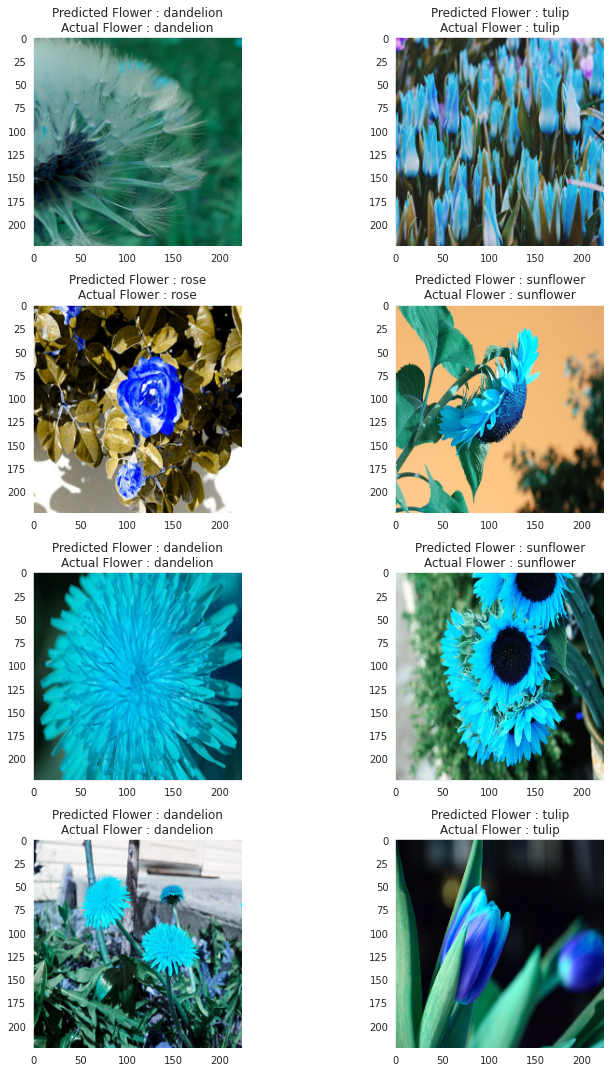

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ labels[predictions[prop_class[count]]] +"\n"+"Actual Flower : "+ labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1

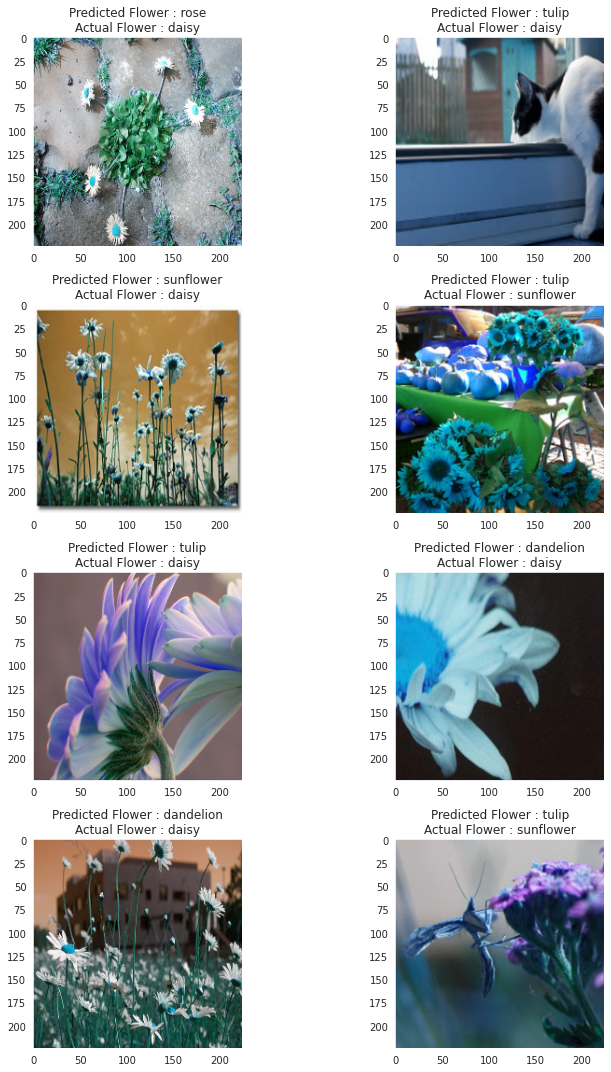

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+labels[predictions[mis_class[count]]]+"\n"+"Actual Flower : "+labels[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count+=1